## Import Libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from arch import arch_model
from scipy.stats import norm, t, skewnorm, weibull_min, lognorm, pareto, gamma, beta, gumbel_r, chi2, logistic
from scipy.optimize import differential_evolution
from scipy.stats import kstest

import warnings
warnings.filterwarnings('ignore')

## Directory

In [2]:
homepath = "C:/A.PROJECTS/stockprediction/"

## Data

In [3]:
stock_prices = pd.read_csv(homepath + 'data/stock_prices_30_tickers.csv',parse_dates=['Date'], index_col='Date')

In [4]:
def compute_returns(df):
    """
    Computes weekly, monthly, quarterly, and annual simple and log returns
    from a DataFrame of daily adjusted prices.

    Args:
        df (pd.DataFrame): DataFrame with daily adjusted prices. The index should be datetime.

    Returns:
        dict: A dictionary containing DataFrames for weekly, monthly, quarterly, and annual simple and log returns.
    """

    # Ensure the index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex.")

    # Function to calculate simple returns
    def calculate_simple_returns(data):
        return data.pct_change().dropna()

    # Function to calculate log returns
    def calculate_log_returns(data):
        return np.log(data).diff().dropna()

    # Resample data and calculate simple returns
    weekly_simple_returns = calculate_simple_returns(df.resample('W').last())
    monthly_simple_returns = calculate_simple_returns(df.resample('M').last())
    quarterly_simple_returns = calculate_simple_returns(df.resample('Q').last())
    annual_simple_returns = calculate_simple_returns(df.resample('Y').last())

    # Resample data and calculate log returns
    weekly_log_returns = calculate_log_returns(df.resample('W').last())
    monthly_log_returns = calculate_log_returns(df.resample('M').last())
    quarterly_log_returns = calculate_log_returns(df.resample('Q').last())
    annual_log_returns = calculate_log_returns(df.resample('Y').last())

    return {
        'weekly_simple': weekly_simple_returns,
        'monthly_simple': monthly_simple_returns,
        'quarterly_simple': quarterly_simple_returns,
        'annual_simple': annual_simple_returns,
        'weekly_log': weekly_log_returns,
        'monthly_log': monthly_log_returns,
        'quarterly_log': quarterly_log_returns,
        'annual_log': annual_log_returns
    }

In [5]:
rets = compute_returns(stock_prices)

## Historical Simulation (bootstraping)

Running scenario: Scenario_1
Running scenario: Scenario_2
Running scenario: Scenario_3
Running scenario: Scenario_4
Running scenario: Scenario_5

Risk Metrics for Different Weighting Scenarios:
     Scenario  Expected Return   VaR 90%   VaR 95%   VaR 99%  CVaR 90%  \
0  Scenario_1         0.000001 -0.000158 -0.000198 -0.000284 -0.000215   
1  Scenario_2         0.000027 -0.000131 -0.000176 -0.000267 -0.000192   
2  Scenario_3        -0.000006 -0.000132 -0.000167 -0.000233 -0.000178   
3  Scenario_4        -0.000094 -0.000243 -0.000285 -0.000365 -0.000298   
4  Scenario_5         0.000105 -0.000008 -0.000039 -0.000099 -0.000049   

   CVaR 95%  CVaR 99%  
0 -0.000252 -0.000323  
1 -0.000232 -0.000319  
2 -0.000207 -0.000264  
3 -0.000334 -0.000408  
4 -0.000076 -0.000130  
Results saved to 'risk_metrics.csv'


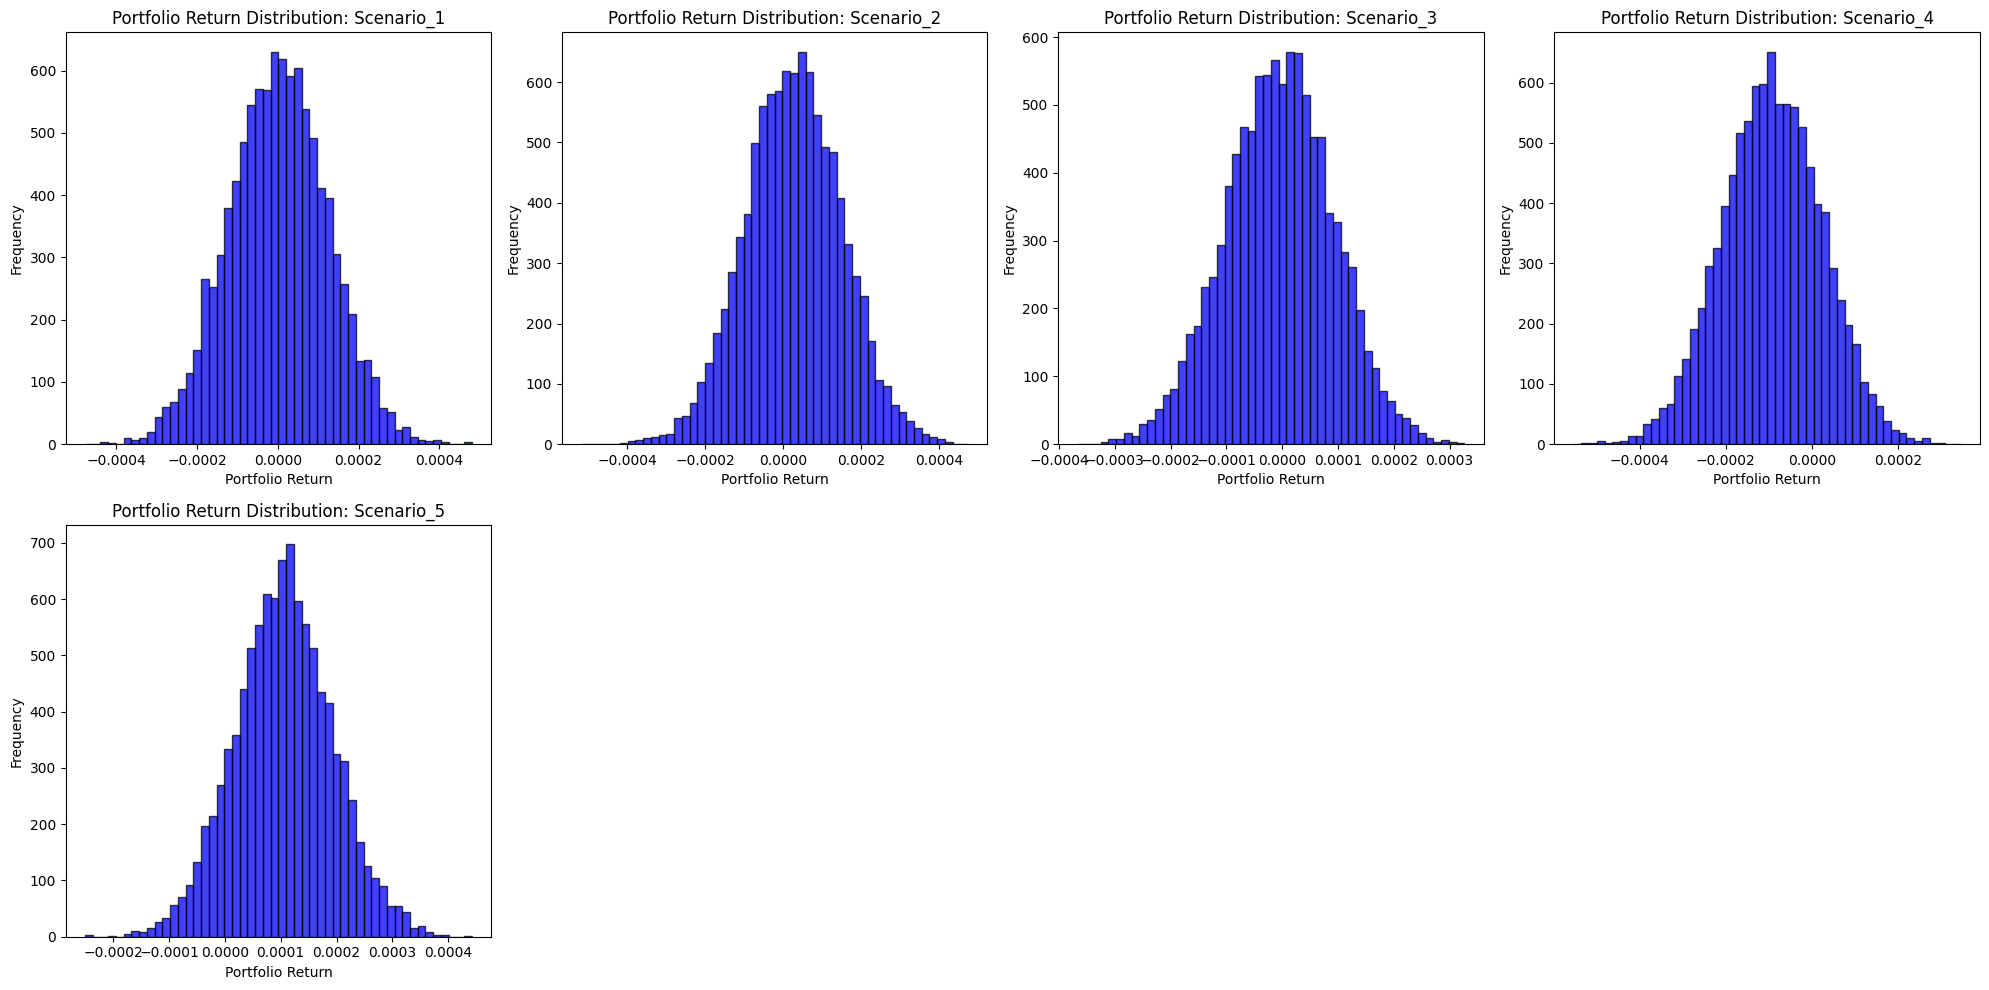

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from arch import arch_model

# Set random seed for reproducibility
np.random.seed(42)

returns_df = rets['weekly_log']
tickers = returns_df.columns
num_weights=returns_df.shape[1]

# Step 2: Create Winsorizer transformer
class Winsorizer(BaseEstimator, TransformerMixin):
    """Transformer to apply winsorization to limit outliers."""

    def __init__(self, lower_quantile=0.05, upper_quantile=0.95):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Apply winsorization to each column in the DataFrame."""
        X = X.copy()
        for col in X.columns:
            lower_bound = np.quantile(X[col], self.lower_quantile)
            upper_bound = np.quantile(X[col], self.upper_quantile)
            X[col] = np.clip(X[col], lower_bound, upper_bound)
        return X


# Step 3: Create GARCHSimulator transformer
class GARCHSimulator(BaseEstimator, TransformerMixin):
    """Fits a GARCH model to each ticker's returns and simulates future returns."""

    def __init__(self, n_simulations=10000, p=1, q=1):
        self.n_simulations = n_simulations
        self.p = p  # GARCH(p, q): order of AR process
        self.q = q  # GARCH(p, q): order of MA process

    def fit(self, X, y=None):
        self.garch_models = {}

        for col in X.columns:
            model = arch_model(X[col], vol="Garch", p=self.p, q=self.q)
            garch_fit = model.fit(disp="off")

            # Store the fitted model
            self.garch_models[col] = garch_fit

        return self

    def transform(self, X):
        simulated_returns = np.zeros((self.n_simulations, X.shape[1]))

        for i, col in enumerate(X.columns):
            garch_fit = self.garch_models[col]
            resids = np.random.normal(0, garch_fit.conditional_volatility[-1], self.n_simulations)
            simulated_returns[:, i] = resids

        return pd.DataFrame(simulated_returns, columns=X.columns)


# Step 4: Create BlockBootstrapper transformer
class BlockBootstrapper(BaseEstimator, TransformerMixin):
    """Performs block bootstrapping to preserve time-series structure and applies weighting."""

    def __init__(self, block_size=5, n_simulations=10000, weights=None):
        self.block_size = block_size
        self.n_simulations = n_simulations
        self.weights = weights  # Weights are passed during initialization

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.weights is None:
            raise ValueError("Weights must be provided during initialization.")

        n_obs, n_assets = X.shape
        blocks = [X.values[i:i + self.block_size] for i in range(n_obs - self.block_size + 1)]
        portfolio_returns = np.empty(self.n_simulations)

        for i in range(self.n_simulations):
            sampled_indices = np.random.randint(0, len(blocks), size=n_obs // self.block_size + 1)
            sampled_blocks = [blocks[idx] for idx in sampled_indices]
            sampled_data = np.vstack(sampled_blocks)[:n_obs]
            portfolio_returns[i] = sampled_data.dot(self.weights).mean()

        return portfolio_returns


# Step 5: Create the pipeline
def create_pipeline(weights):
    return Pipeline([
        ("winsorizer", Winsorizer(lower_quantile=0.05, upper_quantile=0.95)),
        ("garch_simulator", GARCHSimulator(n_simulations=10000)),
        ("block_bootstrapper", BlockBootstrapper(block_size=5, n_simulations=10000, weights=weights)),
    ])


# Step 6:  Generate weighting scenarios (enhanced)
def generate_weighting_scenarios(num_weights):
    """Generates 5 diverse weighting scenarios."""
    scenarios = []
    for i in range(5):
        weights = np.random.dirichlet(np.ones(num_weights))  # Dirichlet distribution for positive weights summing to 1
        scenarios.append(weights)
    return scenarios


# Step 7: Generate Weighting Scenarios and Process Results (Optimized)

weighting_scenarios = {
    f"Scenario_{i+1}": weights
    for i, weights in enumerate(generate_weighting_scenarios(num_weights))
}

# Step 8: Prepare to store results
results = []
simulated_data = {}

# Step 8: Iterate through each weighting scenario
for scenario, weights in weighting_scenarios.items():
    print(f"Running scenario: {scenario}")

    # Create pipeline for this scenario
    pipeline = create_pipeline(weights)

    # Fit and transform the pipeline on the returns data
    simulated_portfolio_returns = pipeline.fit_transform(returns_df)

    # Save simulated data for plotting
    simulated_data[scenario] = simulated_portfolio_returns

    # Step 9: Calculate risk metrics
    mean_return = np.mean(simulated_portfolio_returns)
    var_90 = np.percentile(simulated_portfolio_returns, 10)
    var_95 = np.percentile(simulated_portfolio_returns, 5)
    var_99 = np.percentile(simulated_portfolio_returns, 1)

    cvar_90 = simulated_portfolio_returns[simulated_portfolio_returns <= var_90].mean()
    cvar_95 = simulated_portfolio_returns[simulated_portfolio_returns <= var_95].mean()
    cvar_99 = simulated_portfolio_returns[simulated_portfolio_returns <= var_99].mean()

    # Step 10: Store the results
    results.append({
        "Scenario": scenario,
        "Expected Return": mean_return,
        "VaR 90%": var_90,
        "VaR 95%": var_95,
        "VaR 99%": var_99,
        "CVaR 90%": cvar_90,
        "CVaR 95%": cvar_95,
        "CVaR 99%": cvar_99,
    })

# Step 11: Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nRisk Metrics for Different Weighting Scenarios:")
print(results_df)

# Optional: Save results to CSV
results_df.to_csv(homepath + "data/risk_metrics.csv", index=False)
print("Results saved to 'risk_metrics.csv'")

# Step 12: Plot histograms of portfolio returns for all scenarios

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))  # 2 rows and up to 4 columns
axes = axes.flatten()  # Flatten the axes array for easier indexing

scenarios_to_plot = list(simulated_data.keys())[:7]  # Select up to the first 7 scenarios, if available
for i, scenario in enumerate(scenarios_to_plot):
    ax = axes[i]
    ax.hist(simulated_data[scenario], bins=50, alpha=0.75, color="blue", edgecolor="black")
    ax.set_title(f"Portfolio Return Distribution: {scenario}")
    ax.set_xlabel("Portfolio Return")
    ax.set_ylabel("Frequency")

# Hide any unused subplots if fewer than 8 scenarios exist
for j in range(len(scenarios_to_plot), len(axes)):
    fig.delaxes(axes[j])  # Remove unused subplot areas

plt.tight_layout()
plt.show()


##

## monte carlo

### phase 1: Density Estimation

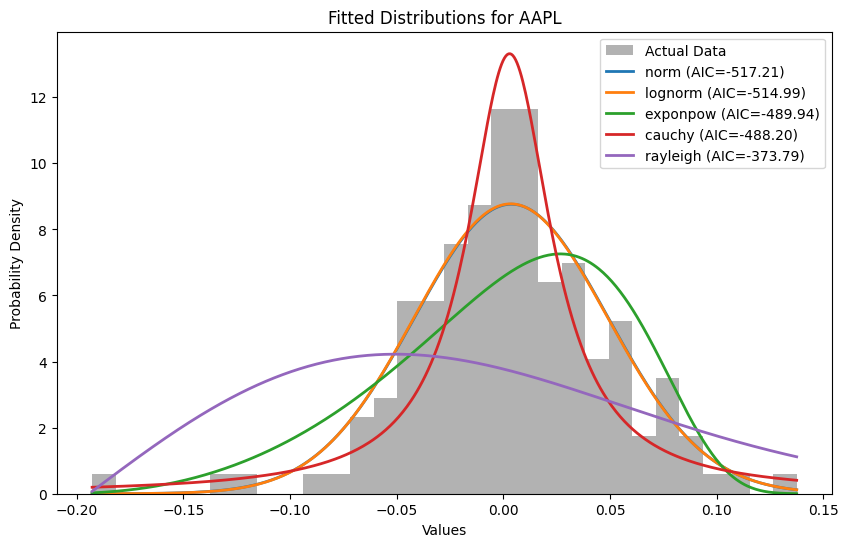

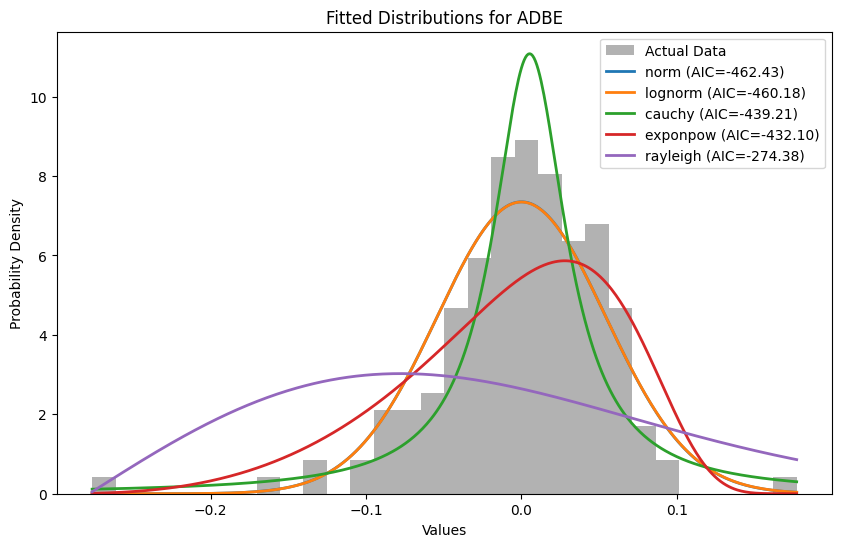

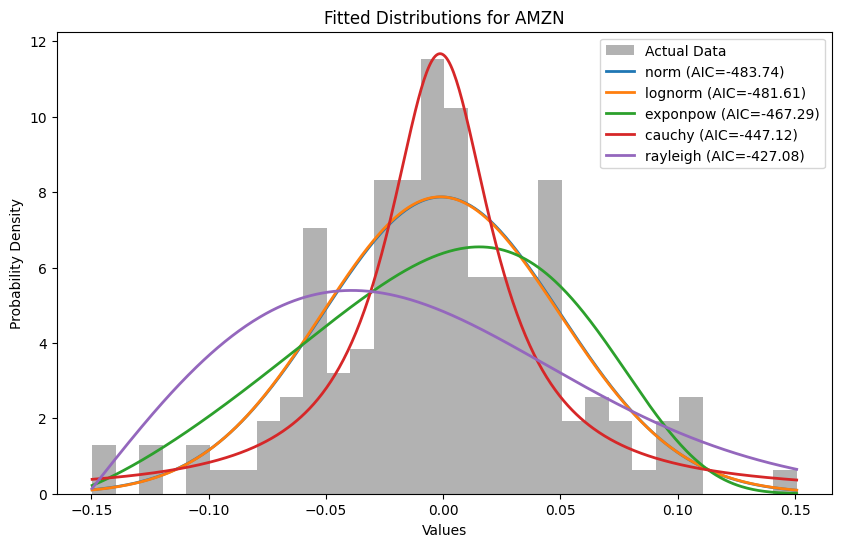

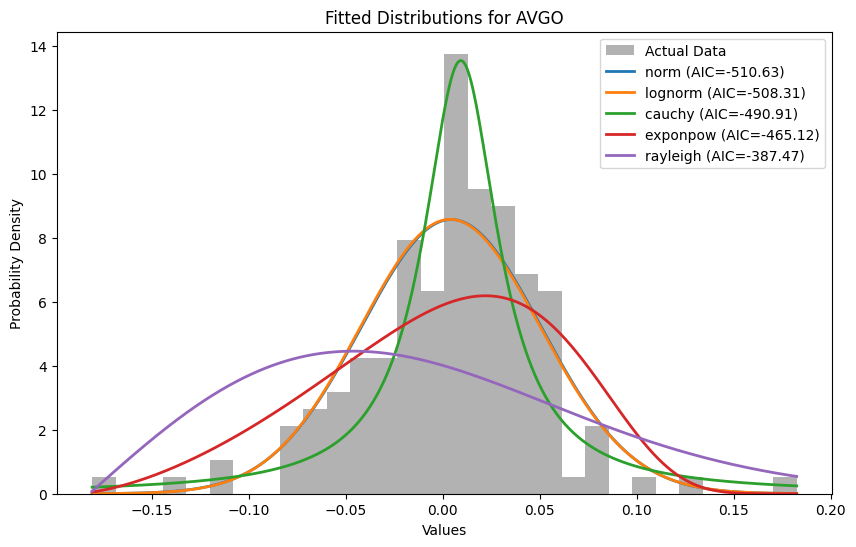

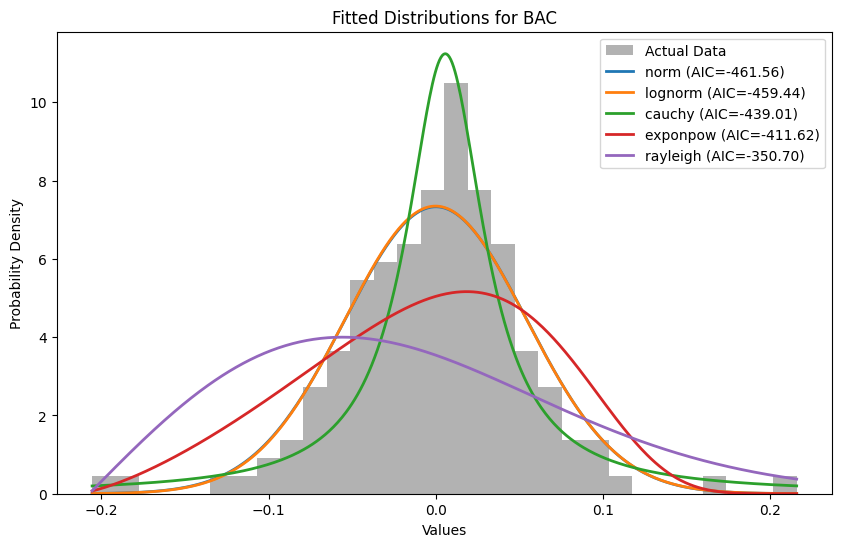

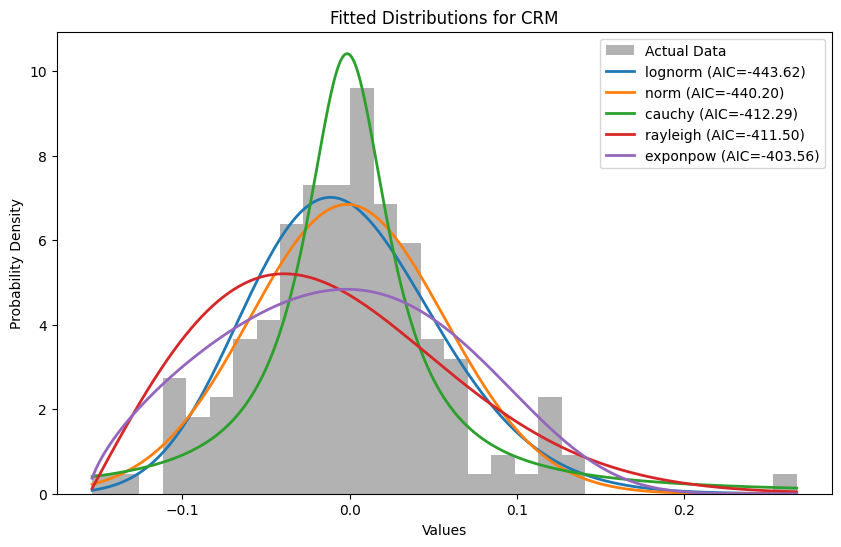

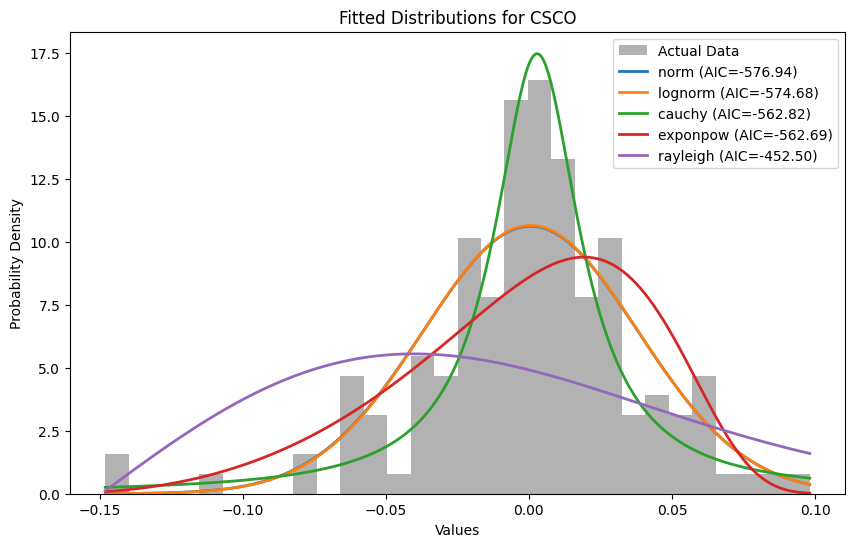

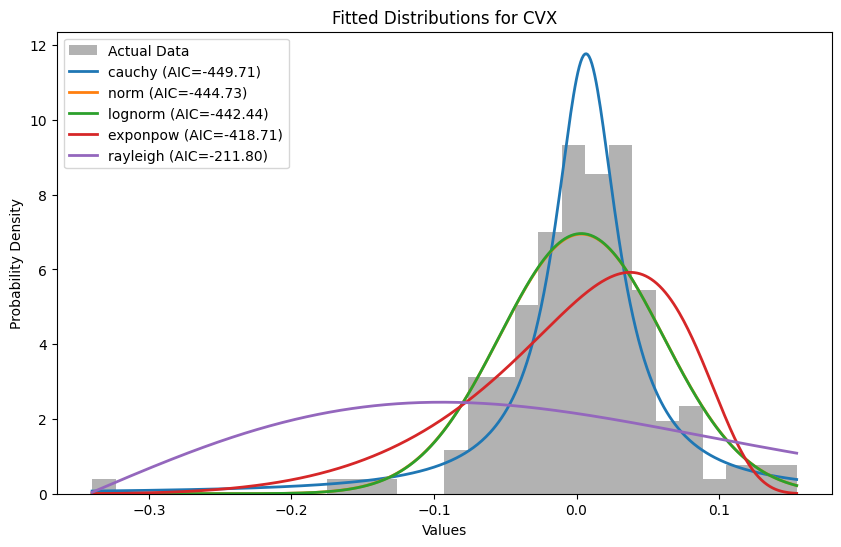

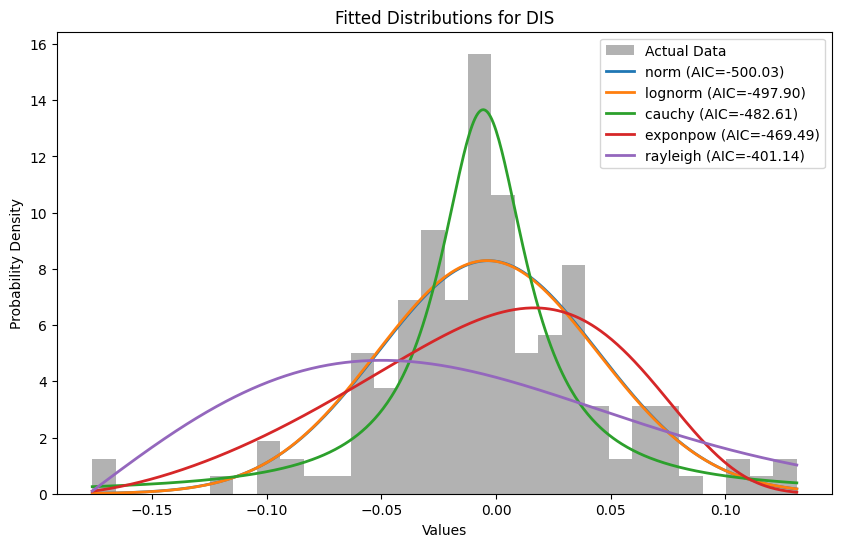

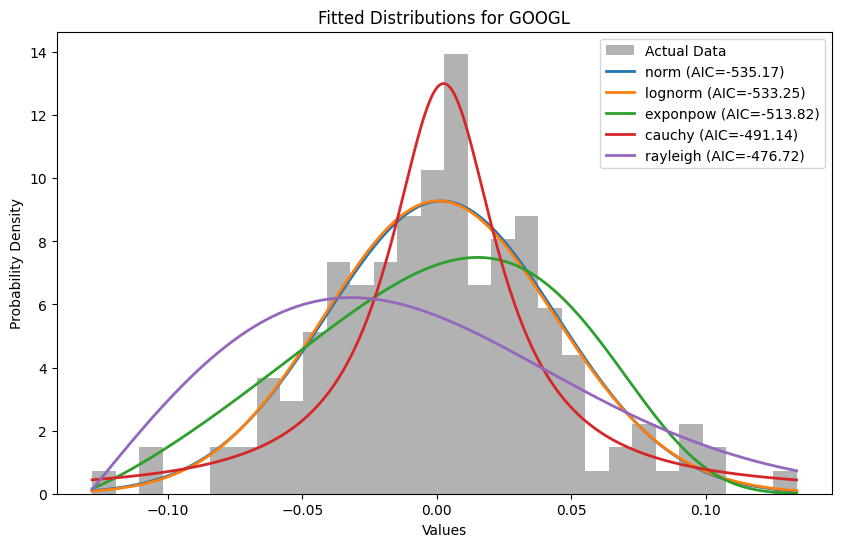

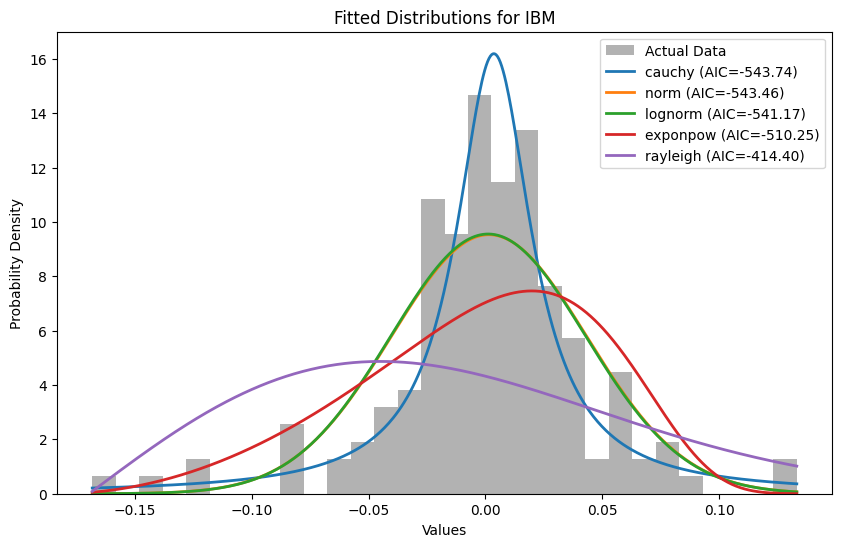

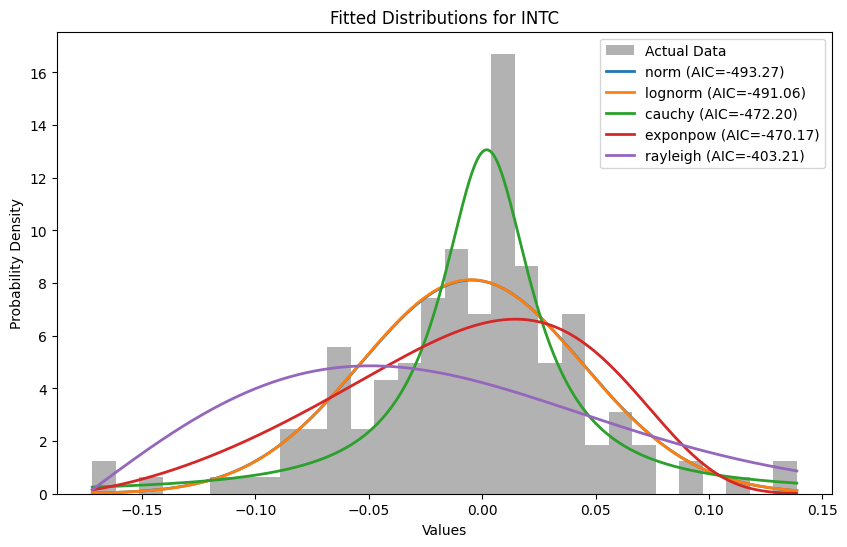

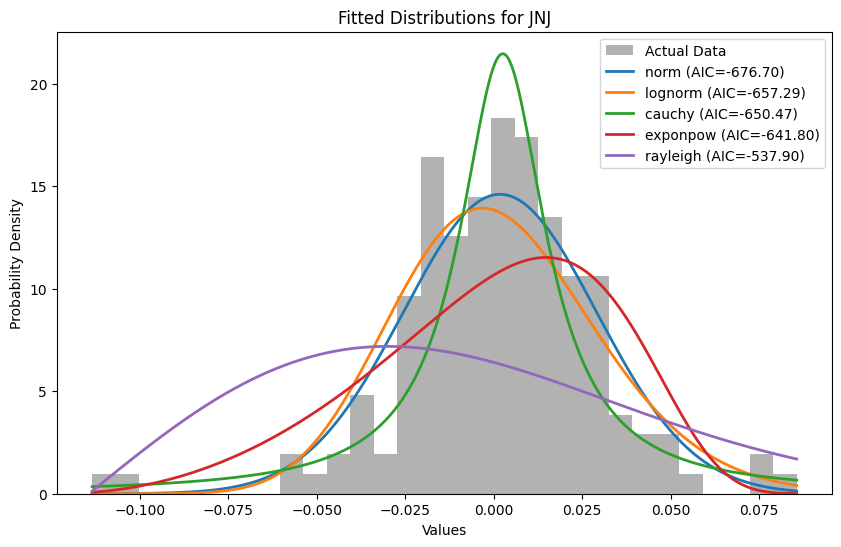

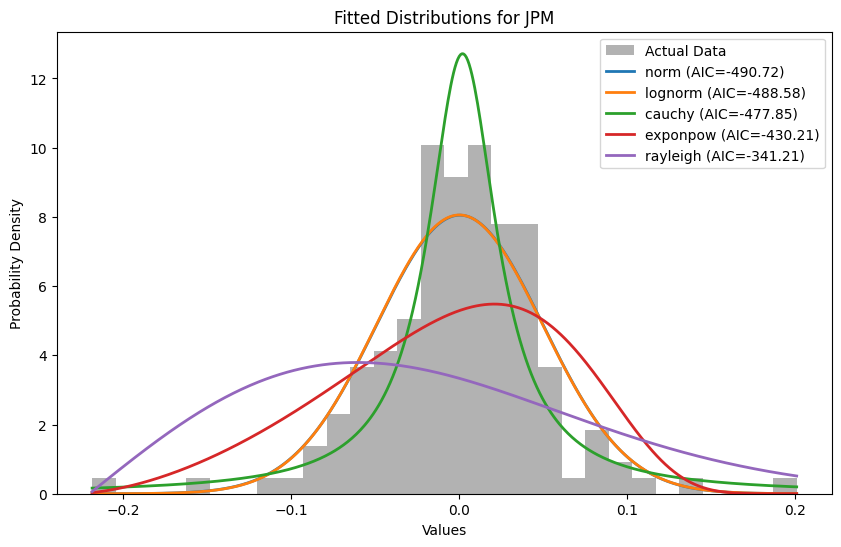

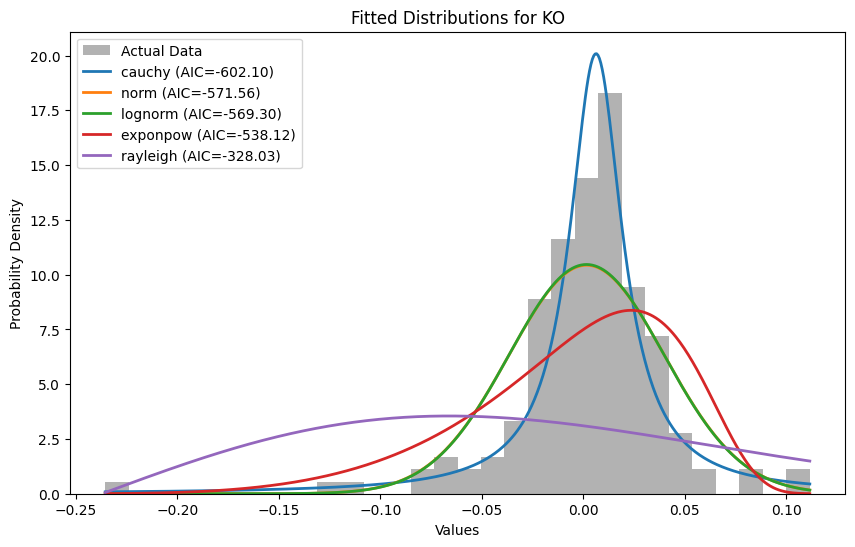

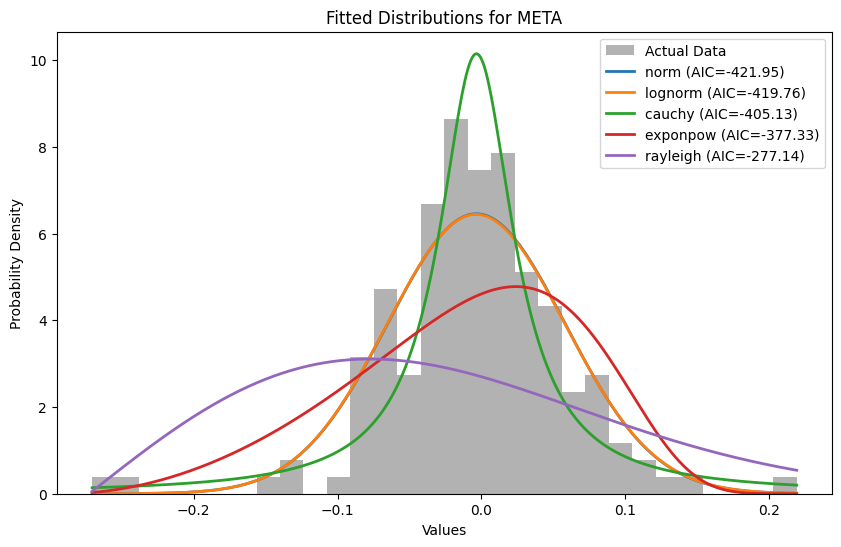

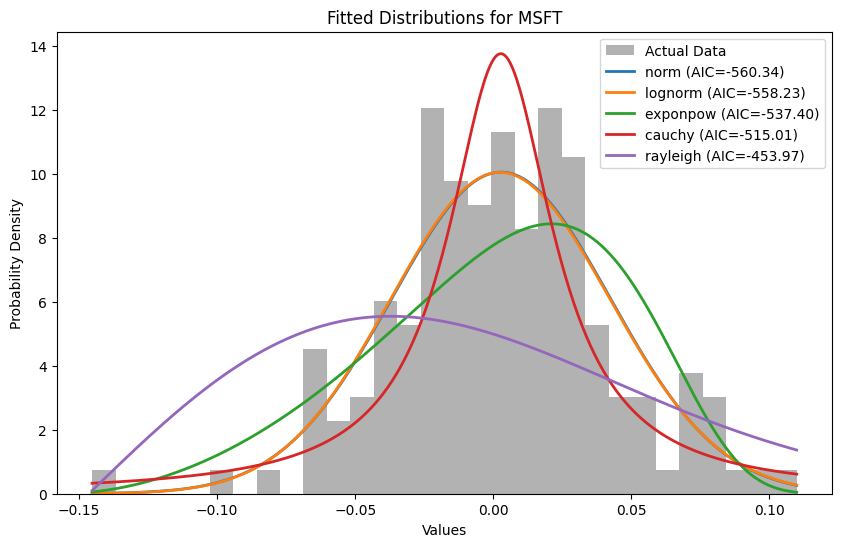

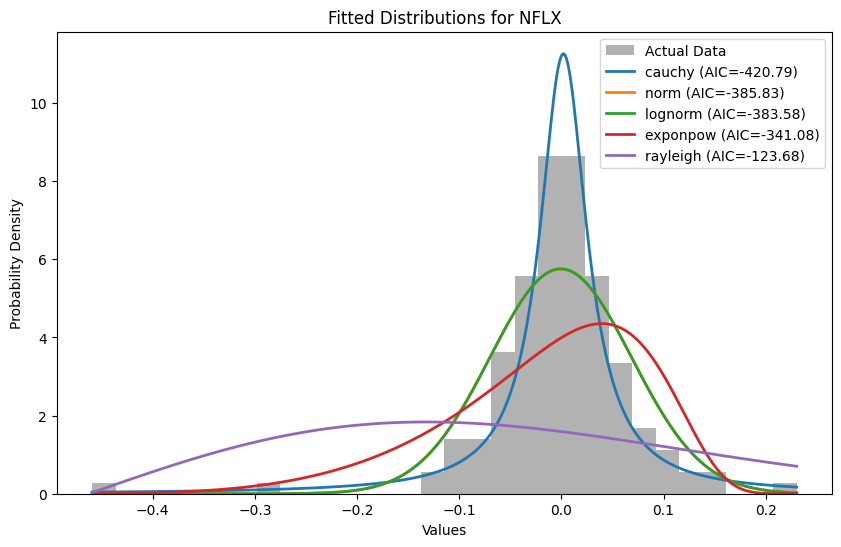

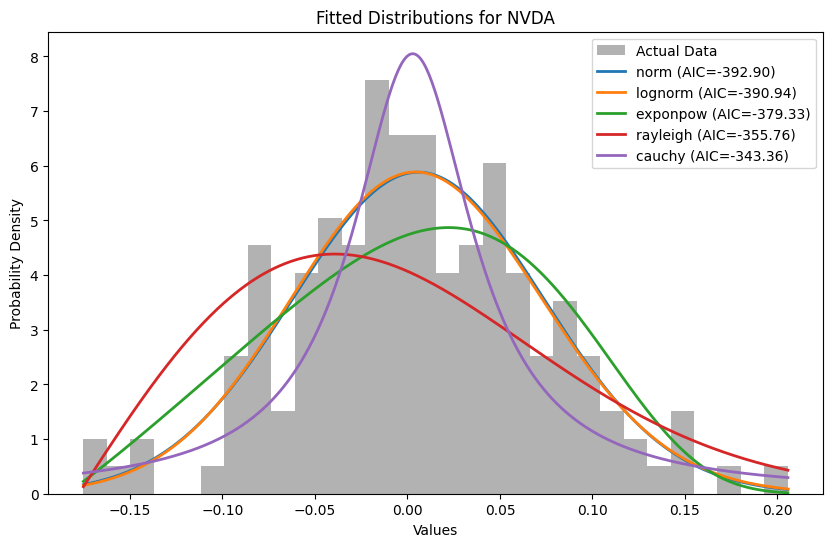

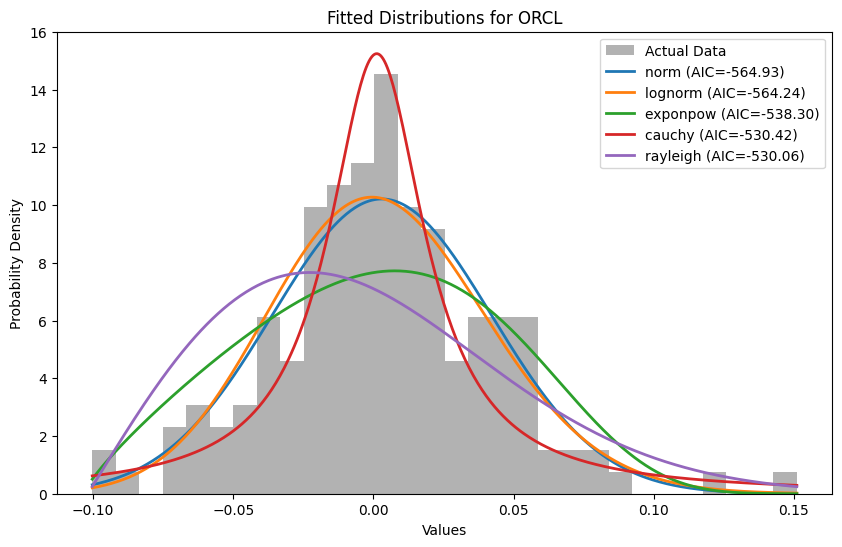

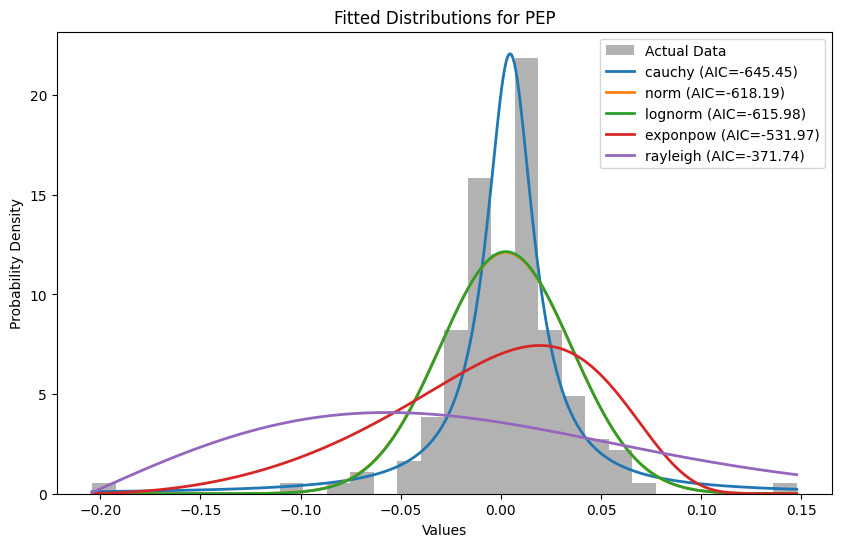

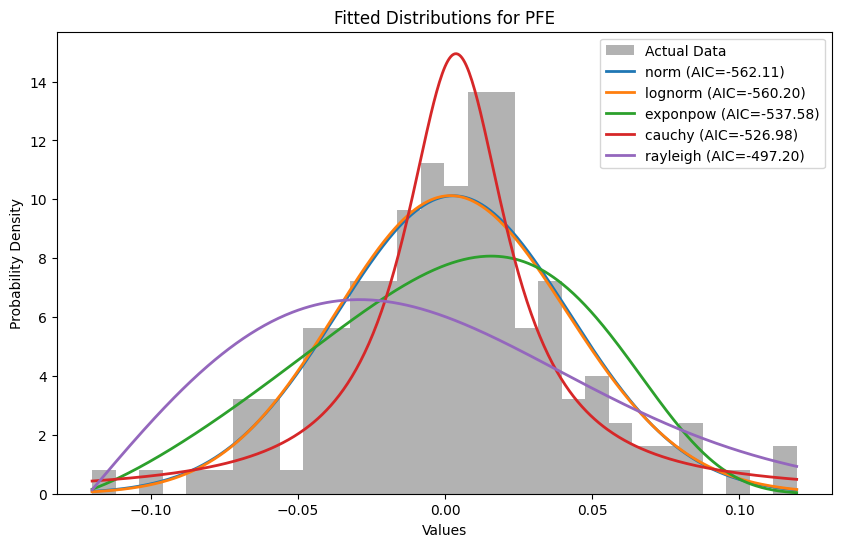

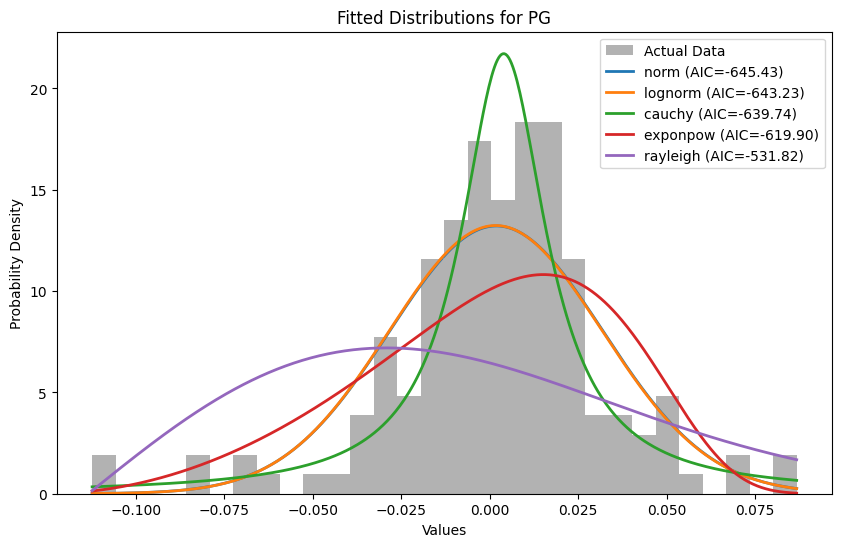

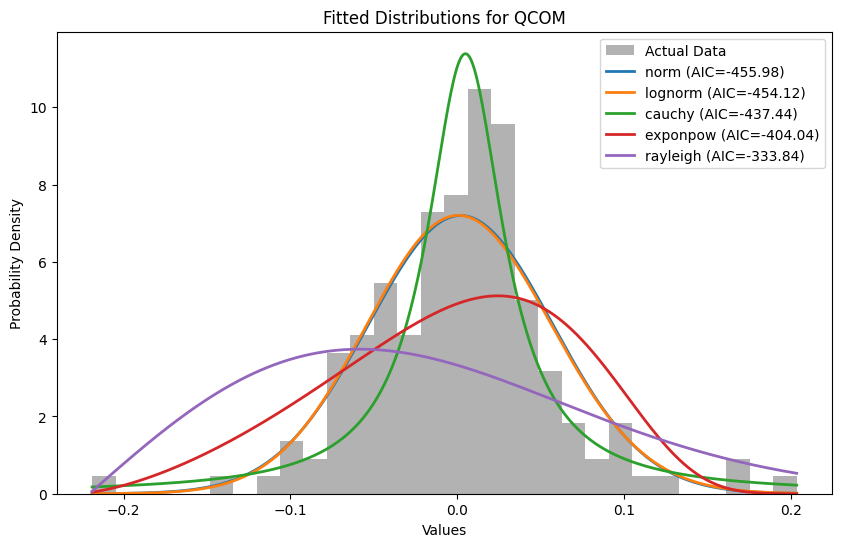

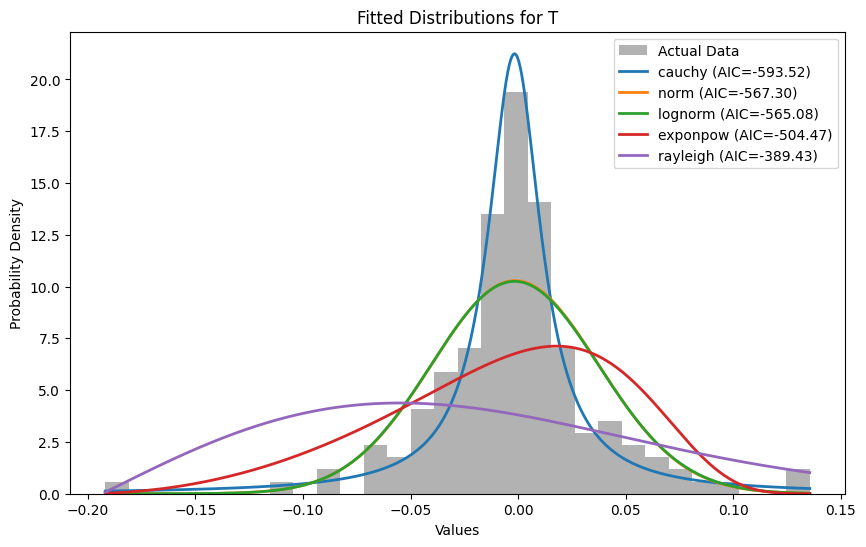

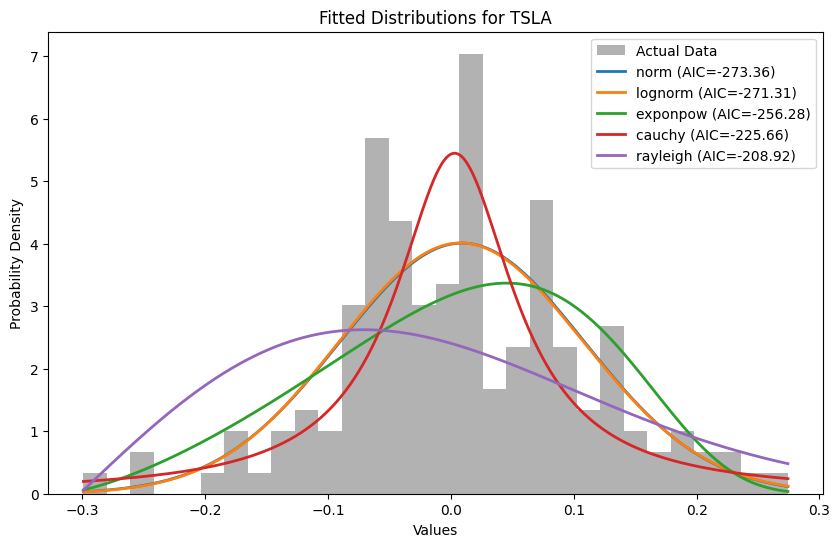

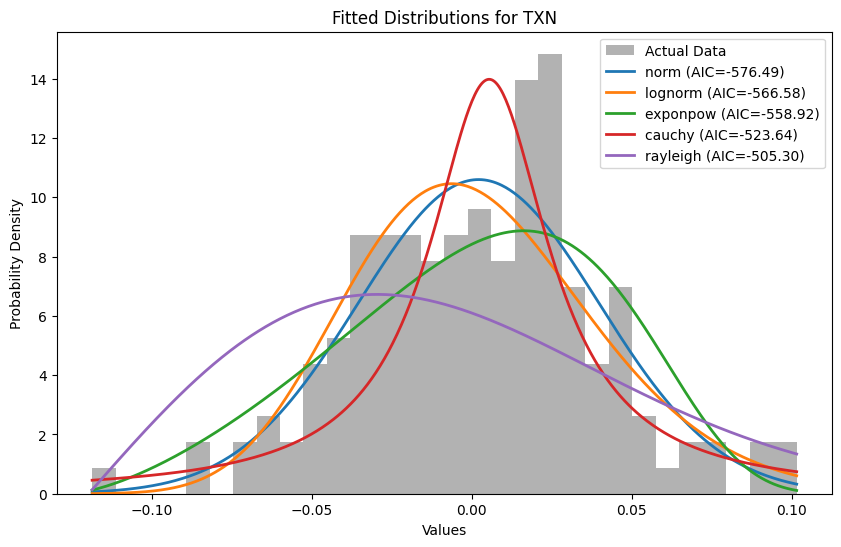

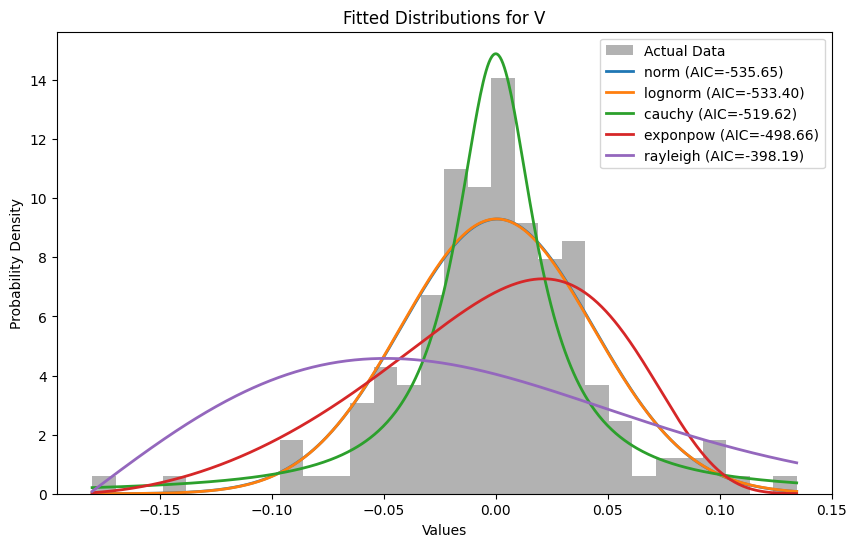

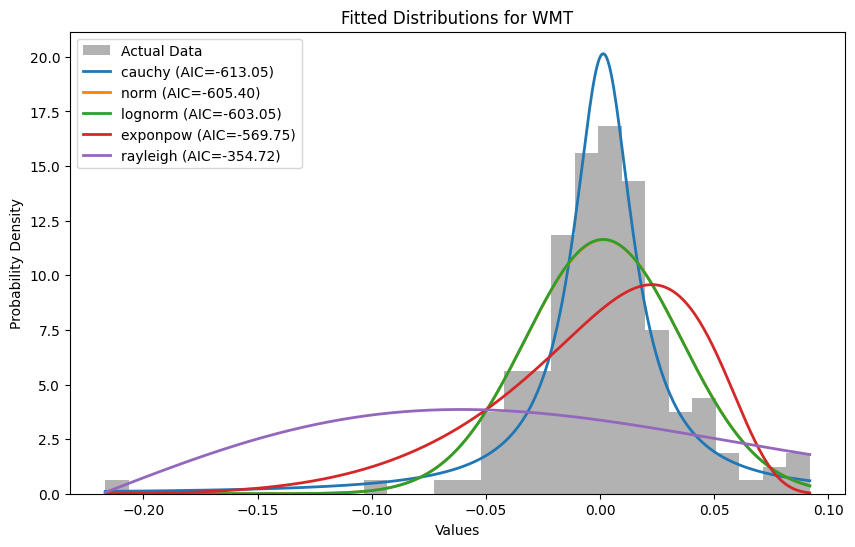

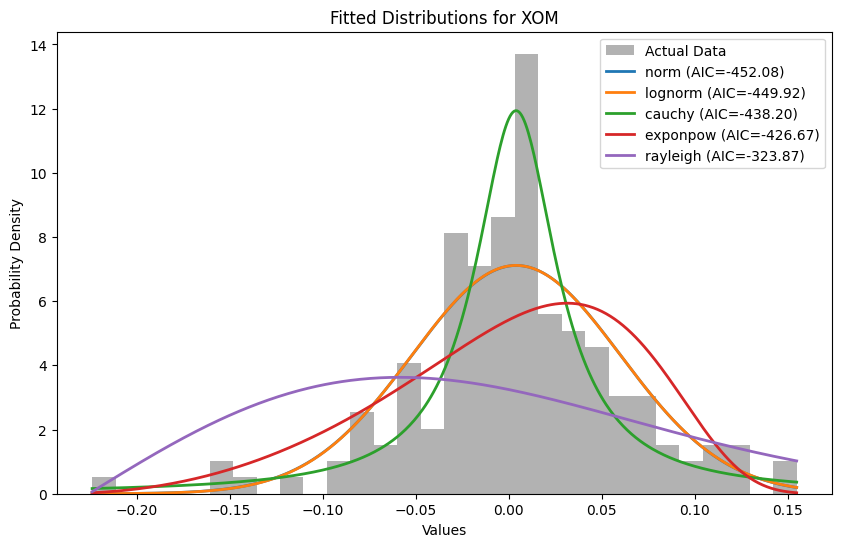

In [66]:
from fitter import Fitter, get_common_distributions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest

# 1. Distribution Evaluation Class
class DistributionEvaluatorWithFitter:
    def __init__(self):
        self.fitter_results = {}

    def fit(self, X, y=None):
        """
        Use the fitter library to fit common distributions and store results,
        excluding the 'chi2' distribution.
        """
        # Ensure X is a pandas DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input to DistributionEvaluatorWithFitter must be a pandas DataFrame.")
        
        self.fitter_results = {}
        # Exclude 'chi2' from the list of common distributions
        common_distributions = [d for d in get_common_distributions() if d not in ['chi2','powerlaw','gamma','expon','uniform']]
        
        for column in X.columns:
            f = Fitter(X[column], distributions=common_distributions)
            f.fit()
            self.fitter_results[column] = f
        return self

    def transform(self, X):
        """
        Evaluate fitted distributions using the Kolmogorov-Smirnov test and sort results by AIC.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input to DistributionEvaluatorWithFitter must be a pandas DataFrame.")
        
        evaluation_results = {}

        for column, fitter_obj in self.fitter_results.items():
            metrics = []

            for dist_name, params in fitter_obj.fitted_param.items():
                try:
                    # Retrieve the corresponding distribution PDF and CDF
                    dist = getattr(__import__('scipy.stats', fromlist=[dist_name]), dist_name)

                    # CDF for KS test
                    cdf = lambda v, dist=dist, params=params: dist.cdf(v, *params)
                    
                    # Apply KS test
                    ks_stat, ks_p_value = kstest(X[column], cdf)
                    
                    # Calculate AIC and BIC
                    n = len(X[column])
                    num_params = len(params)
                    log_likelihood = np.sum(dist.logpdf(X[column], *params))
                    aic = 2 * num_params - 2 * log_likelihood
                    bic = np.log(n) * num_params - 2 * log_likelihood

                    # Append metrics
                    metrics.append({
                        'Distribution': dist_name,
                        'AIC': aic,
                        'BIC': bic,
                        'KS Statistic': ks_stat,
                        'KS p-value': ks_p_value,
                        'params': params
                    })
                except AttributeError:
                    continue
            
            evaluation_results[column] = pd.DataFrame(metrics).sort_values(by='AIC')
        
        return evaluation_results


# 2. Plotting Function
def plot_all_fits_with_fitter(data, evaluation_results, fitter_results):
    """
    Plot the actual data histogram and fitted distributions for each column.
    """
    for column in data.columns:
        plt.figure(figsize=(10, 6))
        
        # Histogram of the actual data
        n, bins, patches = plt.hist(
            data[column], bins=30, density=True, alpha=0.6, color='gray', label='Actual Data'
        )
        
        column_results = evaluation_results.get(column, pd.DataFrame())
        x = np.linspace(data[column].min(), data[column].max(), 500)
        
        # Plot the best-fitted distributions
        for _, row in column_results.iterrows():
            dist_name = row['Distribution']
            params = row['params']
            
            try:
                # Retrieve the corresponding distribution from scipy.stats
                dist = getattr(__import__('scipy.stats', fromlist=[dist_name]), dist_name)
                y = dist.pdf(x, *params)

                plt.plot(x, y, label=f'{dist_name} (AIC={row["AIC"]:.2f})', linewidth=2)
            except AttributeError:
                continue

        plt.title(f"Fitted Distributions for {column}")
        plt.xlabel("Values")
        plt.ylabel("Probability Density")
        plt.legend()
        plt.show()


# 3. Usage Example
# Replace with your actual data, e.g., stock returns or any continuous dataset
stock_returns = rets['weekly_log']

# Instantiate and fit the evaluator
evaluator = DistributionEvaluatorWithFitter()
evaluator.fit(stock_returns)

# Transform the dataset for evaluation
results = evaluator.transform(stock_returns)

# Plot the distributions
plot_all_fits_with_fitter(stock_returns, results, evaluator.fitter_results)


In [72]:
density_list = []
for key in results.keys():
    estimated_dens = results[key]
    chosen_dens = estimated_dens[estimated_dens['KS p-value']==estimated_dens['KS p-value'].max()]
    density_list.append(chosen_dens)

density_df = pd.concat(density_list)[['Distribution','params']]

### Portfolio Simulation

Mean Portfolio Return: 0.0532
Portfolio Return Std Dev: 0.0905
Skewness: -0.0089
Kurtosis: 0.0923


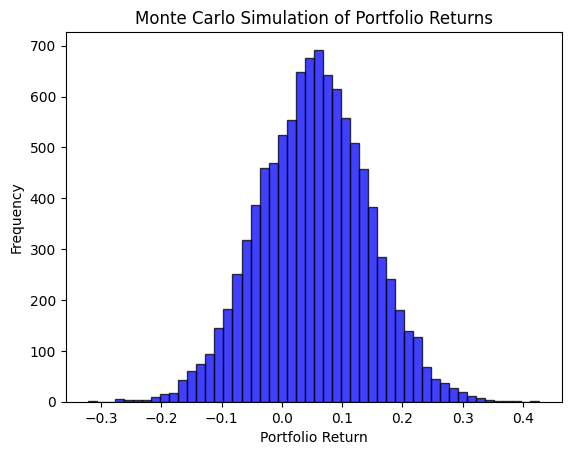

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the number of simulations
num_simulations = 10000

# Example historical returns for three assets (replace with actual data)
historical_returns = pd.DataFrame({
    'Asset1': np.random.normal(0.05, 0.15, 1000),  # mean=5%, stddev=15%
    'Asset2': np.random.normal(0.03, 0.2, 1000),   # mean=3%, stddev=20%
    'Asset3': np.random.normal(0.07, 0.1, 1000)    # mean=7%, stddev=10%
})

# Fit a distribution (here we assume normal distribution for simplicity)
mean_returns = historical_returns.mean()
stddev_returns = historical_returns.std()

# Define portfolio weights (replace with actual portfolio weights)
weights = np.array([0.4, 0.3, 0.3])

# Function to simulate portfolio returns
def monte_carlo_simulation(mean_returns, stddev_returns, weights, num_simulations):
    portfolio_returns = np.zeros(num_simulations)
    for i in range(num_simulations):
        simulated_returns = np.random.normal(mean_returns, stddev_returns)
        portfolio_returns[i] = np.dot(simulated_returns, weights)
    return portfolio_returns

# Run the simulation
simulated_portfolio_returns = monte_carlo_simulation(mean_returns, stddev_returns, weights, num_simulations)

# Analyze the results
mean_portfolio_return = np.mean(simulated_portfolio_returns)
stddev_portfolio_return = np.std(simulated_portfolio_returns)
skewness = pd.Series(simulated_portfolio_returns).skew()
kurtosis = pd.Series(simulated_portfolio_returns).kurt()

# Display the results
print(f"Mean Portfolio Return: {mean_portfolio_return:.4f}")
print(f"Portfolio Return Std Dev: {stddev_portfolio_return:.4f}")
print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")

# Plot the distribution of portfolio returns
plt.hist(simulated_portfolio_returns, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.title('Monte Carlo Simulation of Portfolio Returns')
plt.xlabel('Portfolio Return')
plt.ylabel('Frequency')
plt.show()


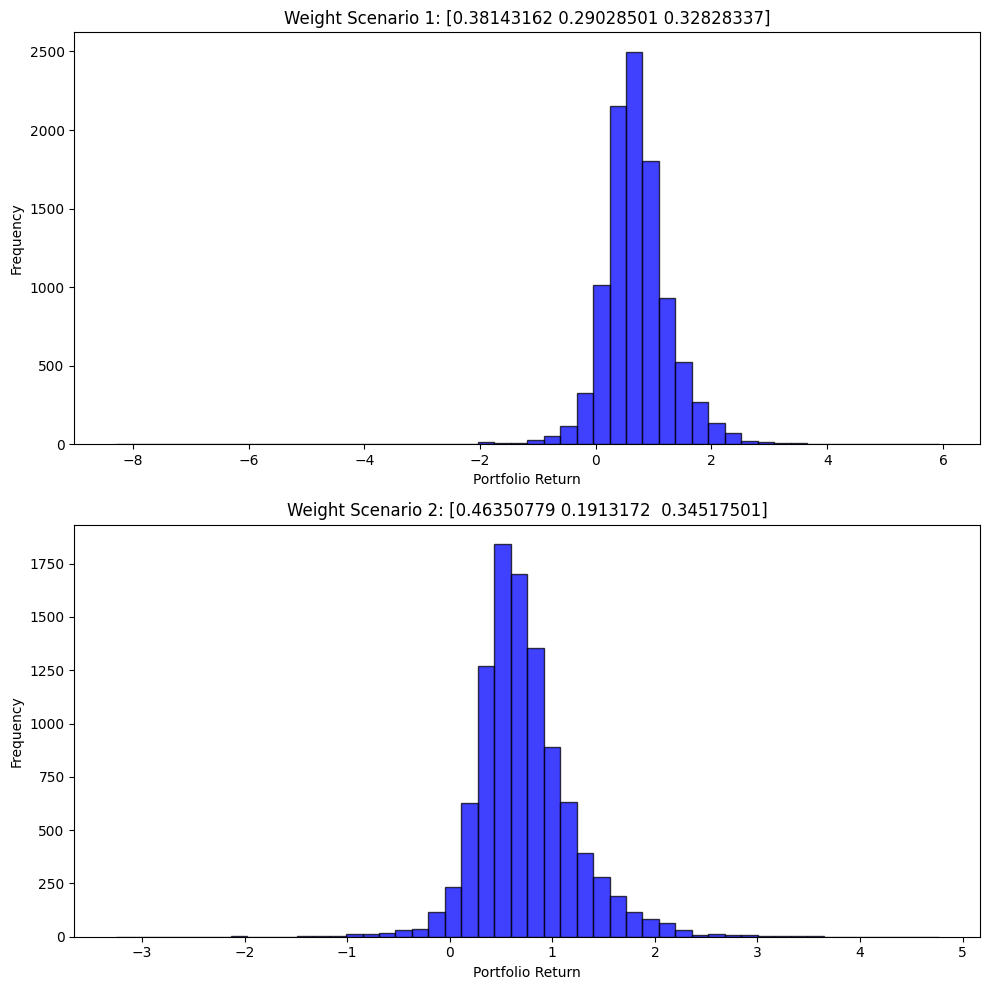

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t, expon  # Example distributions


def generating_weight_scenarios(num_assets, num_scenarios):
    """Generates random weight scenarios for assets.  Improves randomness"""
    weights_scenarios = []
    for _ in range(num_scenarios):
        weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]  # Ensures weights sum to 1
        weights_scenarios.append(weights)
    return np.array(weights_scenarios)


def monte_carlo_simulation_with_distributions(
    correlation_matrix, density_df, weight_scenarios, num_simulations
):
    """
    Performs Monte Carlo simulation with specified distributions and weight scenarios.
    """
    num_assets = correlation_matrix.shape[0]
    simulated_portfolio_returns = []

    for weights in weight_scenarios:
        portfolio_returns = []
        for _ in range(num_simulations):
            asset_returns = np.zeros(num_assets)
            for i in range(num_assets):
                dist_name, params_str = density_df.iloc[i]
                params = [float(x) for x in params_str.split(",")]
                if dist_name == "norm":
                    asset_returns[i] = norm.rvs(*params)
                elif dist_name == "t":
                    asset_returns[i] = t.rvs(*params)
                elif dist_name == "expon":
                    asset_returns[i] = expon.rvs(*params)
                else:
                    raise ValueError(f"Distribution '{dist_name}' not supported.")

            portfolio_returns.append(np.dot(asset_returns, weights))
        simulated_portfolio_returns.append(portfolio_returns)
    return np.array(simulated_portfolio_returns)



def plot_simulated_distributions(simulated_portfolio_returns, weight_scenarios):
    """Plots the simulated portfolio return distributions for each scenario."""
    num_scenarios = len(weight_scenarios)
    fig, axes = plt.subplots(num_scenarios, 1, figsize=(10, 5 * num_scenarios))
    for i, portfolio_returns in enumerate(simulated_portfolio_returns):
        axes[i].hist(portfolio_returns, bins=50, alpha=0.75, color='blue', edgecolor='black')
        axes[i].set_title(f'Weight Scenario {i + 1}: {weight_scenarios[i]}')
        axes[i].set_xlabel('Portfolio Return')
        axes[i].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()



# --- Pipeline ---
# 1. Generate weight scenarios
num_assets = 3
num_scenarios = 2
weight_scenarios = generating_weight_scenarios(num_assets, num_scenarios)

# 2. Define distributions and parameters (modify to reflect your specific data)
density_df = pd.DataFrame({
    "Distributions": ["norm", "t", "expon"],
    "params": ["0.05,0.1", "3,0.1", "1"]  # mean, std, other params
})

# 3. Define Correlation Matrix
correlation_matrix = np.array([[1.0, 0.5, 0.2],
                                [0.5, 1.0, 0.3],
                                [0.2, 0.3, 1.0]])


# 4. Simulate portfolio returns
num_simulations = 10000
simulated_portfolio_returns = monte_carlo_simulation_with_distributions(
    correlation_matrix, density_df, weight_scenarios, num_simulations
)

# 5. Plot the simulated distributions
plot_simulated_distributions(simulated_portfolio_returns, weight_scenarios)
